In [47]:
import torch
import numpy as np
import cv2
# Fixar a semente do Torch para operações específicas
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Importa e plota tensor

In [48]:
#First load libraries and images
import math
import torchvision
from torch import optim
from torch.optim.lr_scheduler import ExponentialLR
from torchvision.transforms import transforms, InterpolationMode
import best.singular_point as sp

transform = transforms.Compose([
    transforms.Resize((sp.args.img_size, sp.args.img_size), interpolation=InterpolationMode.BICUBIC),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

transform2 = transforms.Compose([
    transforms.Resize((sp.args.img_size, sp.args.img_size), interpolation=InterpolationMode.BICUBIC),
    transforms.Grayscale(),
    transforms.ToTensor(),
    transforms.Normalize((0.5), (0.5))
])

trainset = torchvision.datasets.Flowers102(root='./data/datasets', split='train',
                                        download=True, transform=transform2)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=sp.args.batch_size,
                                        shuffle=False, num_workers=2)

In [49]:
iterator=iter(trainloader)
img,labels = next(iterator)
print(img.shape,labels.shape)
img = img.to(sp.device)

torch.Size([16, 1, 120, 120]) torch.Size([16])


### CustonNetDetector

In [50]:
import torch

def save_model(model, filepath):
    torch.save(model.state_dict(), filepath)
    print(f"Model saved to {filepath}")

def load_model(model, filepath):
    model.load_state_dict(torch.load(filepath,map_location=sp.device))
    model.eval()
    print(f"Model loaded from {filepath}")
    

# teste = model.copy()
path_siamese = './data/models/sp_map_fo_30.pth'
sp.args.num_channels = 1
model = sp.SingularPoints(args=sp.args).to(sp.device)
load_model(model,path_siamese)

Namespace(exported=False, num_channels=1, pyramid_levels=3, scale_pyramid=1.3, dim_first=3, dim_second=5, dim_third=8, group_size=36, epochs=70, border_size=12, box_size=21, nms_size=5, img_size=120, batch_size=16, path_data='./data', path_model='model.pt', is_loss_ssim=True, margin_loss=2.0, outlier_rejection=False, show_feature=False)
Model loaded from ./data/models/sp_map_fo_30.pth


In [51]:
PS = 19

def create_circular_mask(h, w, center=None, radius=None):
    if center is None:  # use the middle of the image
        center = (int(w / 2), int(h / 2))
    if radius is None:  # use the smallest distance between the center and image walls
        radius = min(center[0], center[1], w - center[0], h - center[1])
    Y, X = np.ogrid[:h, :w]
    dist_from_center = np.sqrt((X - center[0]) ** 2 + (Y - center[1]) ** 2)
    mask = dist_from_center <= radius
    return mask
 
from torch import nn
class Detector(nn.Module):
        def __init__(self,model) -> None:
           super().__init__()
           self.model = model
        def forward(self, x):
            features_key,features_key_summary,features_ori,features_ori_summary,max_coords_values, max_map= self.model(x)
            return features_key_summary
        
class Detector2(nn.Module):
        def __init__(self,model) -> None:
           super().__init__()
           self.model = model
        def forward(self, x):
            features_key,features_key_summary,features_ori,features_ori_summary,max_coords_values, max_map= self.model(x)
            return features_key
        
class Descriptor(nn.Module):
        def __init__(self,model) -> None:
           super().__init__()           
           self.global_avg_pool = nn.AdaptiveAvgPool2d(1)
           self.global_max_pool = nn.AdaptiveMaxPool2d(1)
           self.mask=torch.tensor(create_circular_mask(PS,PS)).to(sp.device)
        def forward(self, x):
            x = x * self.mask[None][None]
            summary_pool = torch.cat([self.global_avg_pool(x).squeeze(), self.global_max_pool(x).squeeze()], dim=1)
            return summary_pool

detec = Detector(model)
detec2 = Detector2(model)
desc = Descriptor(model)

In [52]:
import torch
import kornia
from kornia.feature.scale_space_detector import get_default_detector_config, MultiResolutionDetector

device = sp.device

keynet_default_config = {
    'num_filters': 8,
    'num_levels': 3,
    'kernel_size': 5,
    'Detector_conf': {'nms_size': 15, 'pyramid_levels': 1, 'up_levels': 1, 'scale_factor_levels': 1.3, 's_mult': 22.0},
}

class CustomNetDetector(MultiResolutionDetector):
    def __init__(
        self,
        model,
        pretrained: bool = False,
        num_features: int = 60,
        keynet_conf=keynet_default_config,
        ori_module=kornia.feature.LAFOrienter(PS),
        aff_module=None,#kornia.feature.LAFAffineShapeEstimator(PS),
    ):
        super().__init__(model, num_features, keynet_conf['Detector_conf'], ori_module, aff_module)


timg_gray = img.to(device)#timg_gray.to(device)
sift = kornia.feature.SIFTDescriptor(PS, rootsift=True).to(device)
descriptor = desc#sift
detector = CustomNetDetector(detec).to(device)


In [53]:
import kornia

class AugmentationParamsGenerator:
    def __init__(self, n, shape):
        torch.manual_seed(0)
        torch.cuda.manual_seed(0)
        
        aug_list = kornia.augmentation.AugmentationSequential(
            kornia.augmentation.RandomAffine(degrees=120, translate=0.05, p=1.0),
            # kornia.augmentation.RandomPerspective(0.05, p=1),
            data_keys=["input"],
            same_on_batch=True,
            # random_apply=10,
        )

        self.index = 0
        self.data = []
        for i in range(n):
            out = aug_list(torch.rand(shape))
            self.data.append(aug_list._params)

    def __iter__(self):
        return self

    def __next__(self):
        if self.index >= len(self.data):
            self.index = 0  # Reset index to start over for circular iteration
            
        result = self.data[self.index]
        self.index += 1
        return result

params_lists =AugmentationParamsGenerator(3,timg_gray.shape)

In [54]:
# def bidirectional_match(feat1, feat2, threshold=0.5):
#     feat1 = feat1.float()
#     feat2 = feat2.float()
    
#     diff = feat1.unsqueeze(1) - feat2.unsqueeze(0)
#     dist_matrix = torch.norm(diff, p=2, dim=2)
    
#     min_indices_feat1_to_feat2 = torch.argmin(dist_matrix, dim=1)
#     min_indices_feat2_to_feat1 = torch.argmin(dist_matrix, dim=0)
#     print(min_indices_feat1_to_feat2.shape,min_indices_feat2_to_feat1.shape)
#     matches = []
#     for i, match_index in enumerate(min_indices_feat1_to_feat2):
#         if min_indices_feat2_to_feat1[match_index] == i:
#             dist = dist_matrix[i, match_index]
#             if dist <= threshold:
#                 matches.append((i, match_index.item()))

#     return torch.tensor(matches)

def bidirectional_match(feat1, feat2, threshold=0.5):
    feat1 = feat1.float()
    feat2 = feat2.float()

    s1, matches1 = kornia.feature.match_snn(feat1, feat2, threshold)
    s2, matches2 = kornia.feature.match_snn(feat2, feat1, threshold)
    
    bidirectional_matches = []
    for i, match in enumerate(matches1):
        indices = torch.where(matches2[:, 0] == match[1].item())[0]
        if indices.numel() > 0:
            for index in indices:
                if matches2[index][1].item() == match[0].item():
                     bidirectional_matches.append((match[0].item(), match[1].item()))
    return torch.tensor(bidirectional_matches)

In [55]:
def detect_and_extract_features(image, detector, descriptor, PS):
    with torch.no_grad():
        lafs, resps = detector(image[None])
        map = detec2(image[None])
        # print('map ',map.shape,image[None].shape)
        patches = kornia.feature.extract_patches_from_pyramid(map, lafs, PS)
        B, N, CH, H, W = patches.size()
        # print('patches  ',patches.shape)
        descs = descriptor(patches.view(B * N, CH, H, W)).view(B, N, -1)
        # print('descs  ',descs.shape)
        return lafs, descs

def compute_homography(lafs1, lafs2, matches):
    src_pts = lafs1[0, matches[:, 0], :, 2].data.cpu().numpy()
    dst_pts = lafs2[0, matches[:, 1], :, 2].data.cpu().numpy()
    F, inliers_mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 1.0, 0.999, 1000)
    inliers_point = matches[torch.from_numpy(inliers_mask).bool().squeeze(), :]
    return inliers_mask

def matching_imagens(ref_img, batch_imgs):
    best_match_info = None
    best_match_count = 0

    with torch.no_grad():
        # Detectar e extrair características da imagem de referência
        lafs_ref, descs_ref = detect_and_extract_features(ref_img, detector, descriptor, PS)

        for i, img in enumerate(batch_imgs):
            # Detectar e extrair características da imagem atual do batch
            lafs_i, descs_i = detect_and_extract_features(img, detector, descriptor, PS)

            # Comparar as características da imagem de referência com a imagem atual do batch
            matches = bidirectional_match(descs_ref[0], descs_i[0], threshold=0.85)

            if matches.shape[0] < 4:
                print("No matches found for image", i)
            else:
                # Cálculo da homografia
                inliers_mask = compute_homography(lafs_ref, lafs_i, matches)
                print(lafs_ref[0][None].shape, lafs_ref[0].shape, matches.shape, inliers_mask.shape)

                # Check if this match is better than the previous best match
                if matches.shape[0] > best_match_count:
                    best_match_info = (lafs_ref[0][None].cpu(), lafs_i[0][None].cpu(), matches.cpu(),
                                       kornia.tensor_to_image(ref_img.cpu()), kornia.tensor_to_image(img.cpu()),
                                       inliers_mask)
                    best_match_count = matches.shape[0]

        if best_match_info is not None:
            # Plot the best match
            from kornia_moons.viz import draw_LAF_matches

            draw_LAF_matches(
                *best_match_info,
                draw_dict={"inlier_color": (0.2, 1, 0.2), "tentative_color": (1, 1, 0.2, 0.3), "feature_color": None, "vertical": False},
            )
        else:
            print("No matches found with enough inliers.")


torch.Size([1, 60, 2, 3]) torch.Size([60, 2, 3]) torch.Size([11, 2]) (11, 1)
torch.Size([1, 60, 2, 3]) torch.Size([60, 2, 3]) torch.Size([4, 2]) (4, 1)
No matches found for image 2
torch.Size([1, 60, 2, 3]) torch.Size([60, 2, 3]) torch.Size([6, 2]) (6, 1)
No matches found for image 4
No matches found for image 5
torch.Size([1, 60, 2, 3]) torch.Size([60, 2, 3]) torch.Size([4, 2]) (4, 1)
torch.Size([1, 60, 2, 3]) torch.Size([60, 2, 3]) torch.Size([4, 2]) (4, 1)
torch.Size([1, 60, 2, 3]) torch.Size([60, 2, 3]) torch.Size([4, 2]) (4, 1)
torch.Size([1, 60, 2, 3]) torch.Size([60, 2, 3]) torch.Size([4, 2]) (4, 1)
No matches found for image 10
No matches found for image 11
No matches found for image 12
No matches found for image 13
No matches found for image 14
No matches found for image 15
##############################################################################################################
No matches found for image 0
torch.Size([1, 60, 2, 3]) torch.Size([60, 2, 3]) torch.Size([18, 2

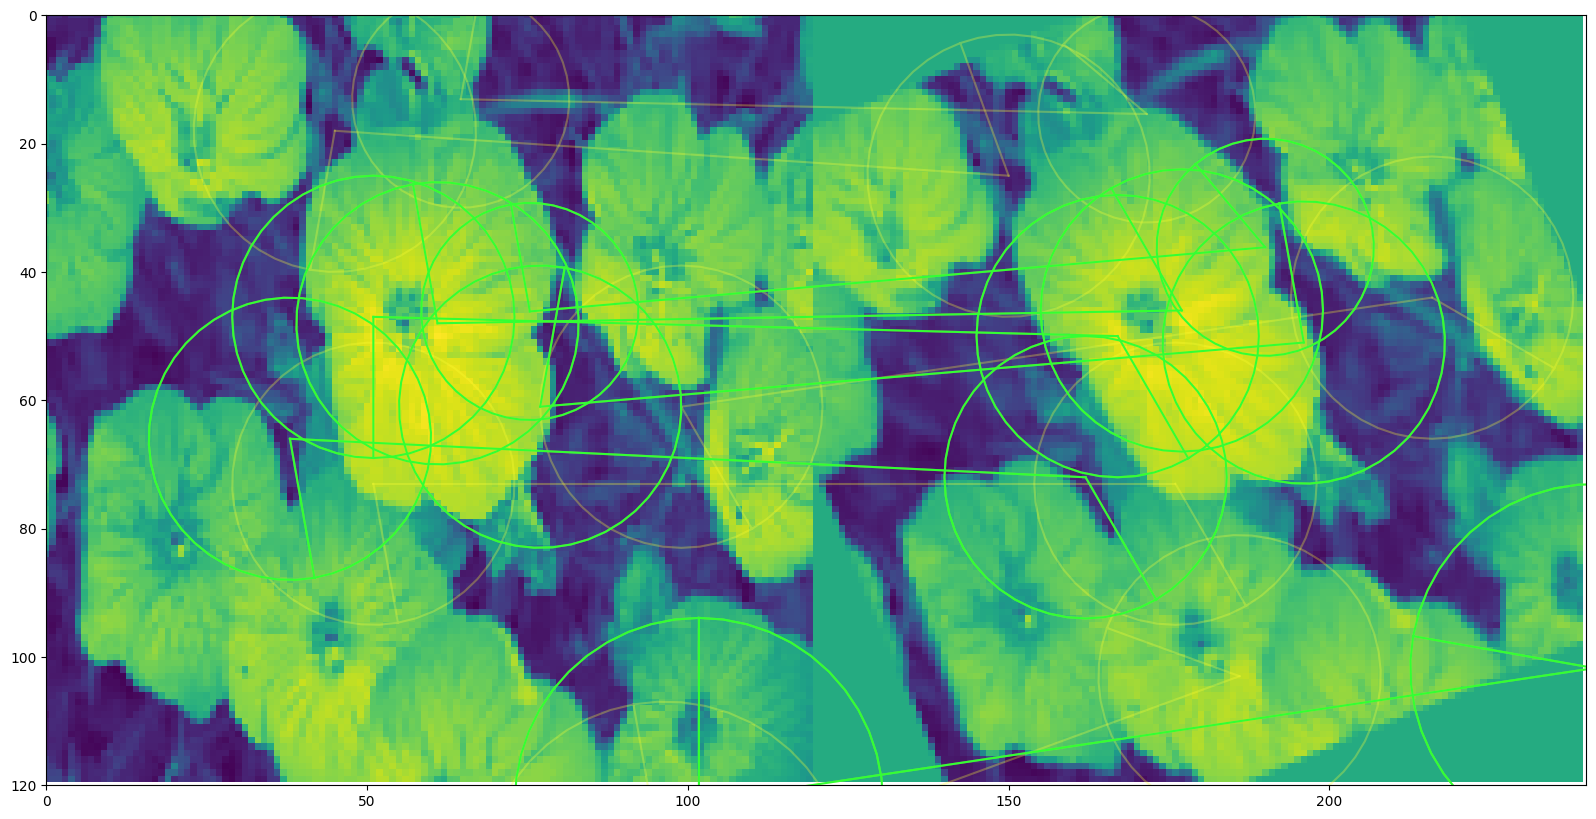

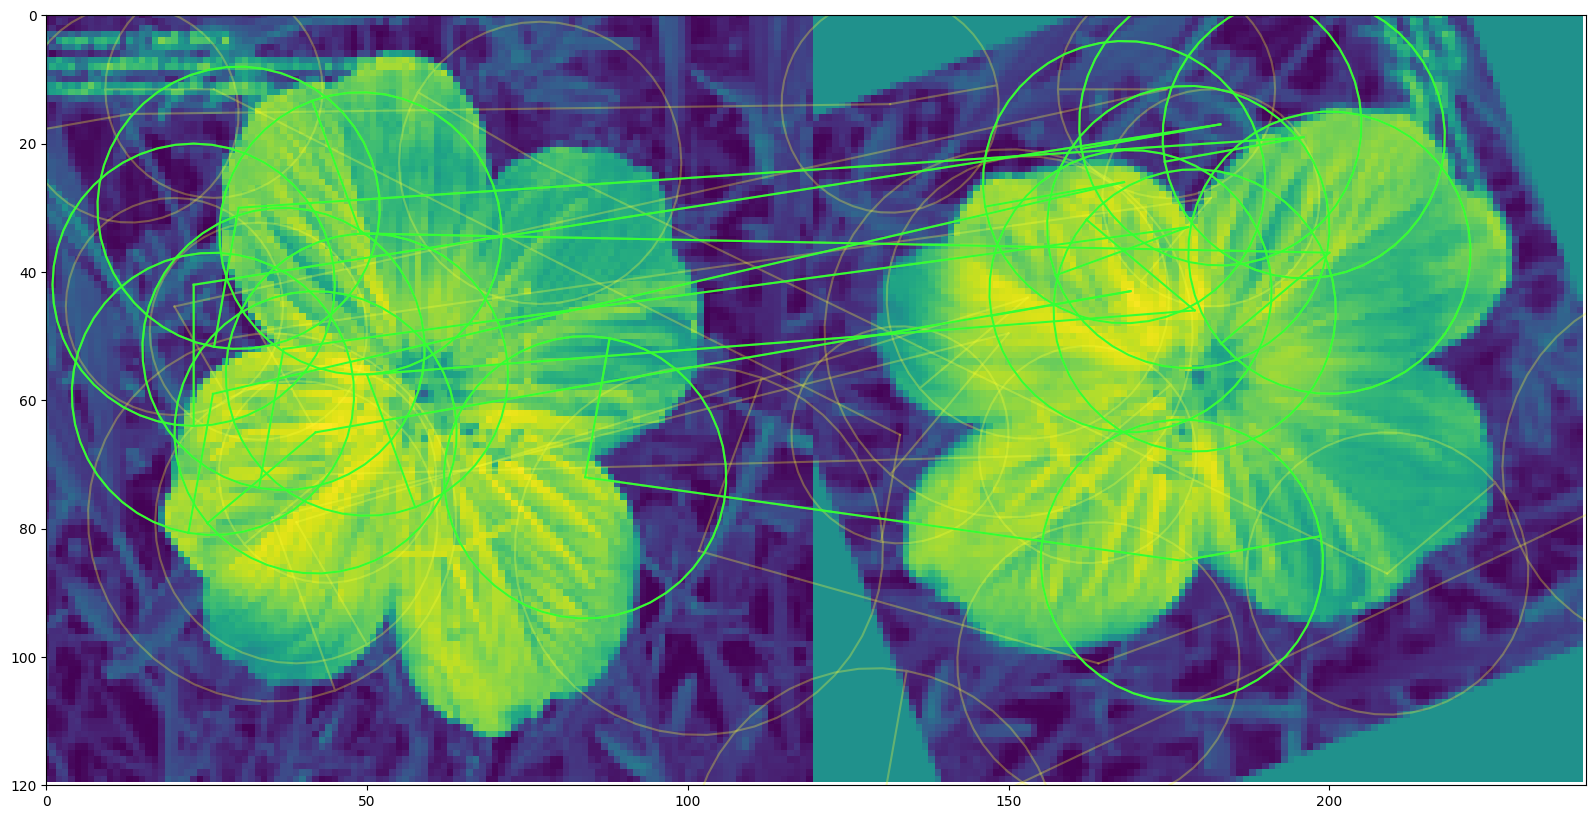

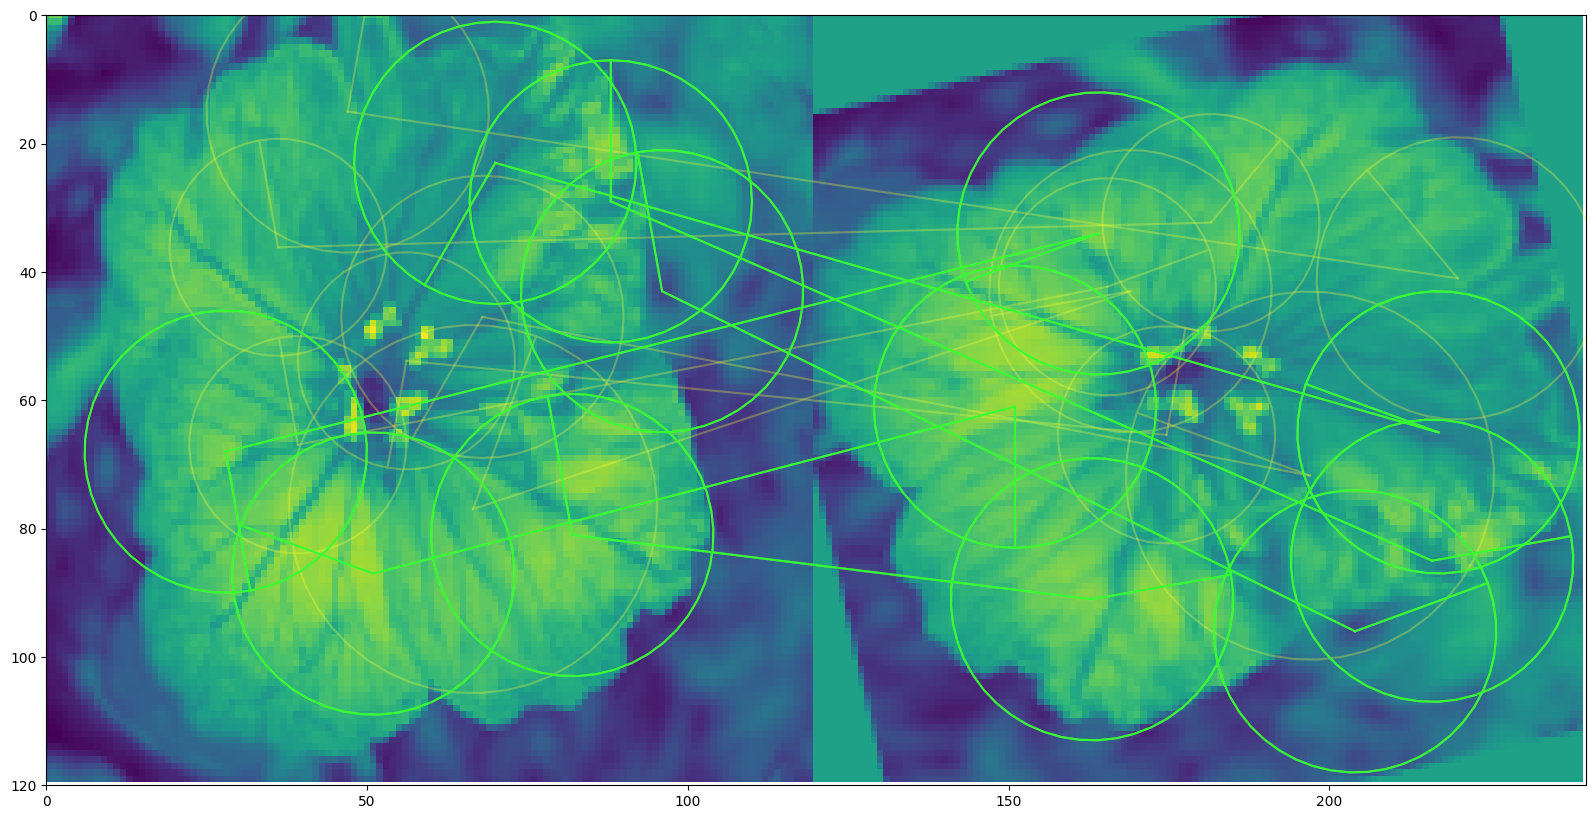

In [56]:
aug_list = kornia.augmentation.AugmentationSequential(
    kornia.augmentation.RandomAffine(degrees=120,translate=0.05,p=1.0),
    # kornia.augmentation.RandomPerspective(0.05, p=1),
    data_keys=["input"],#data_keys=["input", "mask", "bbox", "keypoints"],
    same_on_batch=True,
    # random_apply=15,
)

for i in range(3):
    params_item = next(params_lists)
    timg_gray_t = aug_list(timg_gray,params=params_item)
    matching_imagens(timg_gray[i],timg_gray_t)
    print("##############################################################################################################")

In [57]:
from kornia.feature.laf import get_laf_center,get_laf_orientation,get_laf_scale
get_laf_center(lafs1).shape,get_laf_orientation(lafs1).shape,get_laf_scale(lafs1).shape
get_laf_center(lafs1)[0].shape

# calcular o mathching de imagens com base no batch todo
#interar sobre varios parametros de dataaugmentation

#calcular a posicao dos pontos em relacao a mudança transformacao
#filtrar os pontos em relacao a escala
# computar a correspondencia posicional independente da transformacao com find_best_matching_indices_knn


# calcular o percentual de acerto de correspondencia da descricao na imagem correta e de falso positivo

NameError: name 'lafs1' is not defined